In [118]:
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
from mpl_toolkits.mplot3d import Axes3D
import functions
import random

importlib.reload(functions)

<module 'functions' from 'c:\\Users\\kspin\\Desktop\\EPFL\\MA5\\Stat ML\\functions.py'>

#### KMM w/ non-negativity constraints

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.778954614513536
        x: [ 2.224e+00  9.845e-01 ...  0.000e+00  1.148e-01]
      nit: 7
      jac: [-1.121e-06  1.366e-06 ... -9.104e-07 -3.531e-06]
     nfev: 2408
     njev: 8
 hess_inv: <300x300 LbfgsInvHessProduct with dtype=float64>


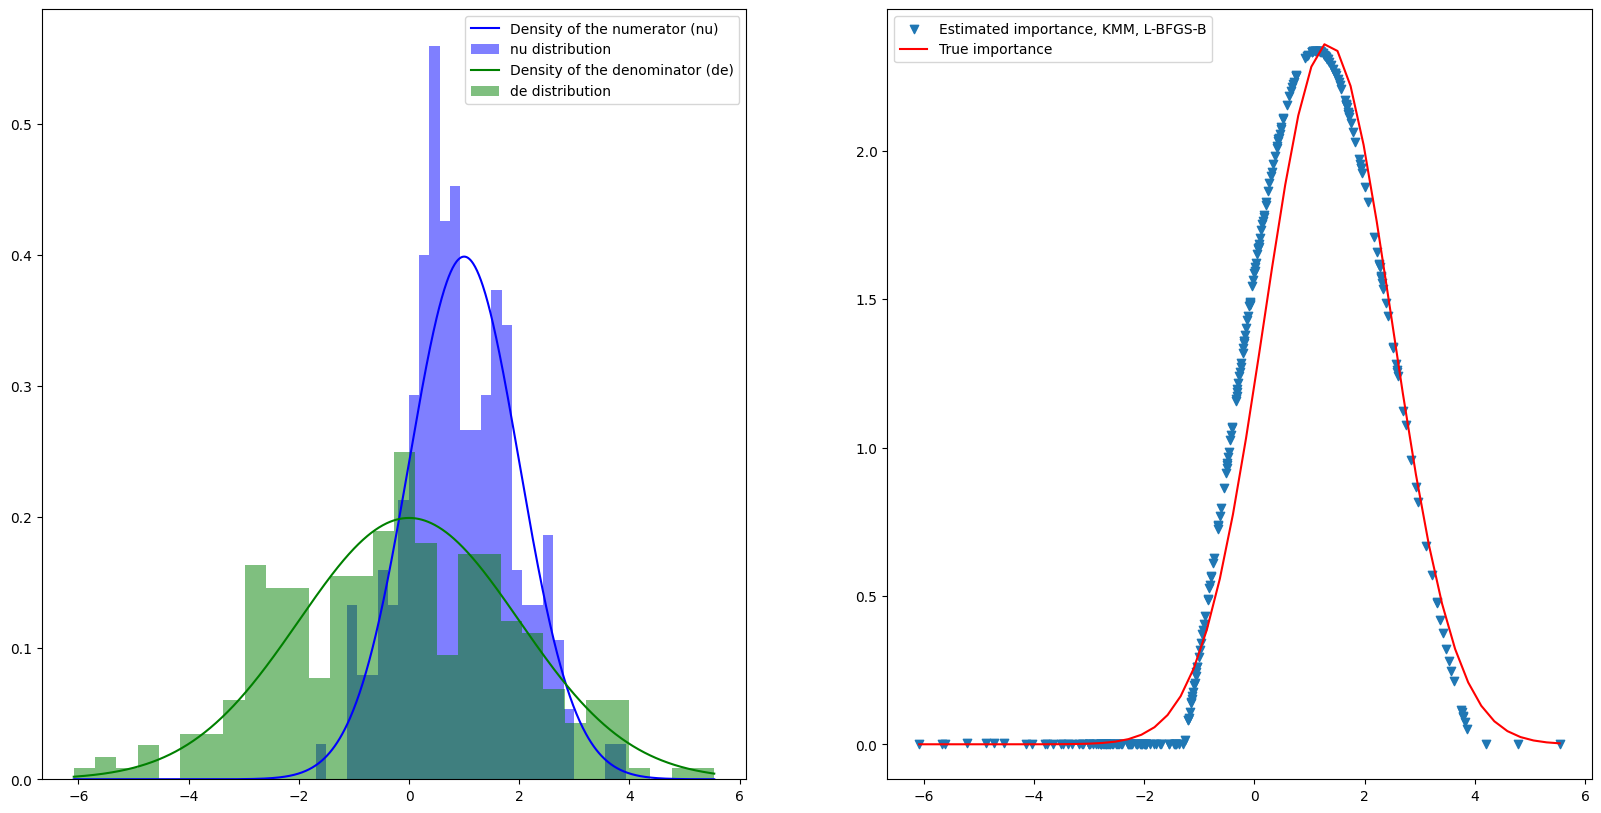

In [11]:
plot_precision = 1000

# inital parameters
n_nu, mu_nu, sigma_nu = 200, 1, 1
n_de, mu_de, sigma_de = 300, 0, 2

# create randomized data
nu_data = np.random.normal(loc = mu_nu, scale = sigma_nu, size = n_nu)
de_data = np.random.normal(loc = mu_de, scale = sigma_de, size = n_de)

# define densities functions for comparison
f_nu = lambda x: 1/np.sqrt(2*np.pi*sigma_nu**2)*np.exp(-(x - mu_nu)**2/(2*sigma_nu**2))
f_de = lambda x: 1/np.sqrt(2*np.pi*sigma_de**2)*np.exp(-(x - mu_de)**2/(2*sigma_de**2))

# ratio to be estimated
w = lambda x: f_nu(x)/f_de(x)

tmp_nu = list(nu_data)
tmp_de = list(de_data)

n_nu = len(nu_data)
n_de = len(de_data)
l = []


for i in range(n_nu):
    for j in range(n_de):
        l.append(np.linalg.norm(nu_data[i]- de_data[j]))

#combined = sorted(tmp_nu + tmp_de) 
l = sorted(l)
sigma = np.median(l)


K = lambda x,y: np.exp(-(x-y)**2/(2*sigma**2))
r1 = functions.KMM_inf_approach_w_nonneg(de_data, nu_data, "L-BFGS-B", K)
x = np.linspace(min(min(de_data), min(nu_data)), max(max(de_data), max(nu_data)), plot_precision)
x2 = np.linspace(min(de_data), max(de_data))

_, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(x, f_nu(x), label = "Density of the numerator (nu)", color = "blue")
ax[0].hist(nu_data, density = True, color = "blue", label = "nu distribution", alpha = 0.5, bins = 30)
ax[0].plot(x, f_de(x), label = "Density of the denominator (de)", color = "green")
ax[0].hist(de_data, density = True, color = "green", label = "de distribution", bins = 30, alpha = 0.5)
#ax[0].plot(x, w(x), label = "Importance", color = "red")
ax[0].legend()
ax[1].scatter(de_data, r1, label = "Estimated importance, KMM, L-BFGS-B", marker = "v")
ax[1].plot(x2, w(x2), label = "True importance", color = "red")
ax[1].legend()



In [53]:
w = de_data
n_de = len(de_data)
K_de = np.array([[K(de_data[i], de_data[j]) for j in range(n_de)] for i in range(n_de)])+ 10e-2 * np.eye(n_de)
print(w.reshape(-1,1).shape)
print(K_de.shape)

np.transpose(w.reshape(-1,1)) @ K_de @ w-np.transpose(w.reshape(-1,1)) @ K_de @ np.ones((n_de, 1))

(300, 1)
(300, 300)


array([[68865.77008145]])

#### IWERM

setup for IWERM

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.34444306342848097
        x: [ 9.637e-02  7.647e-01  1.036e+00]
      nit: 11
      jac: [-3.114e-06 -7.749e-06 -5.636e-06]
 hess_inv: [[ 7.632e-01 -4.320e-01  2.037e-01]
            [-4.320e-01  8.102e-01 -4.297e-01]
            [ 2.037e-01 -4.297e-01  3.358e-01]]
     nfev: 72
     njev: 18


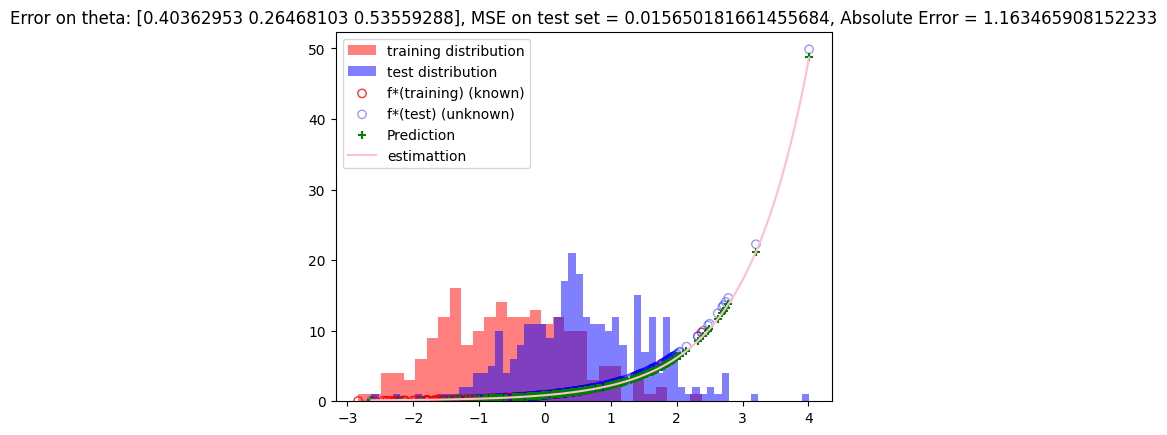

In [5]:
true_f = lambda x: np.exp(x-0.1)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = -0.5, 1
mu_te, sigma_te = 1/2, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
#x_tr = -np.random.exponential(mu_tr, n_tr)
#x_tr = np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

plt.hist(x_tr, bins = 30, color = "r", label = "training distribution", alpha = 0.5)
plt.hist(x_te, bins = 60, color = "b", label = "test distribution", alpha = 0.5)
plt.scatter(x_tr, y_tr, facecolors = 'none', edgecolors = 'r', label = "f*(training) (known)", alpha = 0.8)
plt.scatter(x_te, y_te, facecolors = 'none', edgecolors = 'b', label = "f*(test) (unknown)", alpha = 0.4)

#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
perturbation = 0.5
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)
dim_theta = 3
#dimension_of_parameter = n_te
#theta = np.zeros((1, n_te))
#f = lambda x, theta: np.sum([theta[i] * K(x, x_te[i]) for i in range(n_te)])

#f = lambda x, theta: x*theta
L = lambda x,y: np.linalg.norm(x-y)**2

#theta_opti = functions.IWCV(f, dimension_of_parameter, L, x_te, training_set, 0.5, 0.2)
theta_opti, f_opti = functions.IWERM(f, dim_theta, L, x_te, training_set, 0.5, 0.2)


#f_opti = lambda x: f(x, theta_opti)
#print(theta_opti)
plt.scatter(x_te, f_opti(x_te), label ="Prediction", color = "green", marker = "+")
y_2 = np.linspace(min(x_te), max(x_te),100)
plt.plot(y_2, f_opti(y_2), color = "pink", label ="estimattion")


#Compute MSE on test set:
avg_MSE_test = np.linalg.norm(f_opti(x_te) - y_te) / n_te
AE = max(np.abs(f_opti(x_te) - y_te))

plt.title(f"Error on theta: {np.abs(theta_opti - perturbation)}, MSE on test set = {avg_MSE_test}, Absolute Error = {AE}")
plt.legend()

IWERM gamma-theta plots

In [ ]:
true_f = lambda x: np.exp(x+5)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = 1/2, 1
mu_te, sigma_te = 0, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

perturbation = 0.5
#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)     # parametric family of choice
dim_theta = 3

L = lambda x,y: np.linalg.norm(x-y)**2

params_variation_size = 20
lambda_grid = np.linspace(0,1, params_variation_size)
gamma_grid = np.linspace(0,1, params_variation_size)

grid_search = np.empty((len(gamma_grid), len(lambda_grid)), dtype=object)


for i in range(len(gamma_grid)):
    for j in range(len(lambda_grid)):
        tmp, _ = functions.IWERM(f, dim_theta, L, x_te, training_set, gamma_grid[i], lambda_grid[j])
        print("ici: ", tmp)
        grid_search[i, j] = tmp


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2.73380695261222e-09
        x: [-1.137e-04  1.484e+02  1.000e+00]
      nit: 19
      jac: [-7.580e-07  1.145e-05  5.416e-03]
 hess_inv: [[ 3.167e+00 -2.126e+00  5.234e-03]
            [-2.126e+00  1.774e+00 -4.555e-03]
            [ 5.234e-03 -4.555e-03  1.211e-05]]
     nfev: 228
     njev: 54
ici:  [-1.13724326e-04  1.48413257e+02  9.99999742e-01]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1019.5729385451516
        x: [ 1.964e+01  1.312e+02  1.047e+00]
      nit: 20
      jac: [ 0.000e+00  0.000e+00 -7.629e-06]
 hess_inv: [[ 1.868e-04  3.752e-04 -1.548e-06]
            [ 3.752e-04  7.539e-04 -3.456e-06]
            [-1.548e-06 -3.456e-06  3.595e-07]]
     nfev: 208
     njev: 52
ici:  [ 19.64128315 131.20495714   1.04746768]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status:

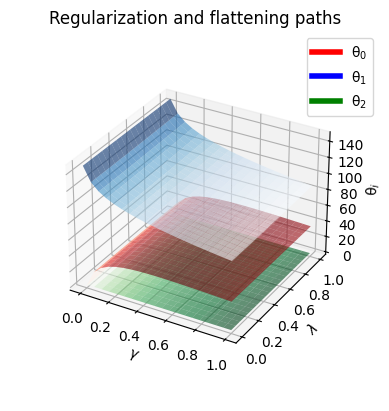

In [8]:
# print(grid_search)
theta_0 = [[x[0].item() for x in result] for result in grid_search]
theta_1 = [[x[1].item() for x in result] for result in grid_search]
theta_2 = [[x[2].item() for x in result] for result in grid_search]
Z0 = np.array([val for sublist in theta_0 for val in sublist]).reshape(20,20)
Z1 = np.array([val for sublist in theta_1 for val in sublist]).reshape(20,20)
Z2 = np.array([val for sublist in theta_2 for val in sublist]).reshape(20,20)

plt.rcParams['legend.fontsize'] = 10


plotx,ploty = np.meshgrid(gamma_grid,lambda_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(plotx,ploty, Z0, alpha=0.6, cmap='Reds', label='θ$_0$')
ax.plot_surface(plotx,ploty, Z1, alpha=0.6, cmap='Blues', label='theta1')
ax.plot_surface(plotx,ploty, Z2, alpha=0.6, cmap='Greens', label='theta2')

red_patch = plt.Line2D([0], [0], color='red', lw=4, label='θ$_0$')
blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='θ$_1$')
green_patch = plt.Line2D([0], [0], color='green', lw=4, label='θ$_2$')

ax.set(xlabel=('$\gamma$'), ylabel=('$\lambda$'), zlabel=('θ$_i$'))
ax.set_title("Regularization and flattening paths")
ax.legend(handles=[red_patch, blue_patch, green_patch])
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()

In [126]:
params_variation_size = 10
gamma_grid = np.linspace(0,1, params_variation_size)

M = []
STD = []

for gamma in gamma_grid:
    res = []
    for iteration in range(10):

        random.seed(iteration)

        true_f = lambda x: np.exp(x+5)

        n_tr = 200
        n_te = 300

        mu_tr, sigma_tr = 1, 1/2
        mu_te, sigma_te = 2, 1/4

        x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr, size = n_tr)
        x_te = np.random.normal(loc = mu_te, scale = sigma_te, size = n_te)

        y_tr = true_f(x_tr)
        y_te = true_f(x_te)

        training_set = np.zeros((2, n_tr))
        training_set[0, :], training_set[1, :] = x_tr, y_tr

        #f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
        #f = lambda x, theta: (x- theta + perturbation)**2
        #f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
        f = lambda x, theta: theta[0] + theta[1]*x    # parametric family of choice
        dim_theta = 3

        

        L = lambda x,y: np.linalg.norm(x-y)**2
        k_folds = 5

        res.append(functions.IWCV(f,dim_theta,L,x_te,training_set,k_folds,gamma))

        s = f"Estimated {iteration+1}/10 for gamma: {gamma}"
        print(s, end="\r")

    res = np.array(res)
    M.append(np.mean(res))
    STD.append(np.std(res))

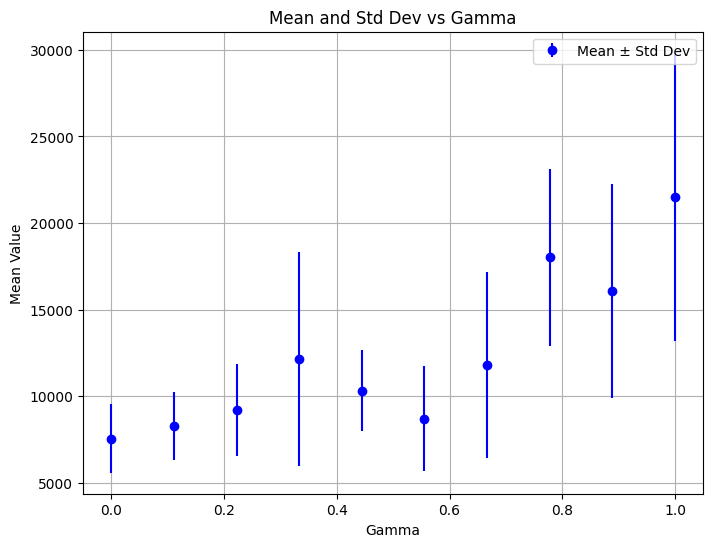

In [127]:
plt.figure(figsize=(8, 6))
plt.errorbar(gamma_grid, M, yerr=STD, fmt='o', color='b', label='Mean ± Std Dev')
plt.title('Mean and Std Dev vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Mean Value')
plt.grid(True)
plt.legend()
plt.show()

In [128]:

random.seed(2025)
true_f = lambda x: np.exp(x+5)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = 1/2, 1
mu_te, sigma_te = 0, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr, size = n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

perturbation = 0.5

params_variation_size = 10
#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)     # parametric family of choice
dim_theta = 3

gamma_grid = np.linspace(0,1, params_variation_size)

L = lambda x,y: np.linalg.norm(x-y)**2
k_folds = 10

resss = []
for gamma in gamma_grid:
    resss.append(functions.IWCV(f,dim_theta,L,x_te,training_set,k_folds,gamma))

    
print(resss)

[np.float64(5.693366539693208e-09), np.float64(5.6368600091812965e-09), np.float64(5.591019405234718e-09), np.float64(5.555053851033474e-09), np.float64(5.528277601754968e-09), np.float64(5.5100998947020445e-09), np.float64(5.500016183172264e-09), np.float64(5.497600614322436e-09), np.float64(5.502499631443538e-09), np.float64(5.5144265992362055e-09)]


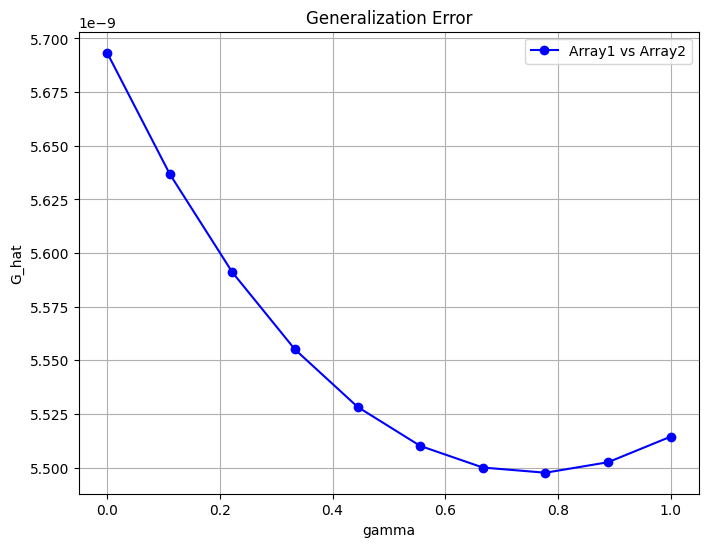

In [129]:
plt.figure(figsize=(8, 6))
plt.plot(gamma_grid, resss, marker='o', linestyle='-', color='b', label='Array1 vs Array2')
plt.title('Generalization Error')
plt.xlabel('gamma')
plt.ylabel('G_hat')
plt.grid(True)
plt.legend()
plt.show()